## 1. Load Library

In [1]:
!pip install -U efficientnet -qq

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
import os
import shutil
import json

from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Creating a function to streamline the Train data set   
def train_img_path(id_str):
    return os.path.join(r"/kaggle/input/histopathologic-cancer-detection/train", f"{id_str}.tif")

## 2. Exploratory Data Analysis

Image Shape = (96, 96, 3)


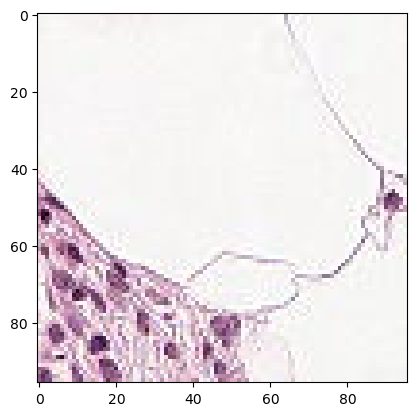

In [4]:
example_path = "/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

In [5]:
train_labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,/kaggle/input/histopathologic-cancer-detection...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,/kaggle/input/histopathologic-cancer-detection...
2,755db6279dae599ebb4d39a9123cce439965282d,0,/kaggle/input/histopathologic-cancer-detection...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,/kaggle/input/histopathologic-cancer-detection...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,/kaggle/input/histopathologic-cancer-detection...


In [6]:
train_labels_df.shape

(220025, 3)

In [7]:
train_labels_df["label"][0]

'0'

In [8]:
set(train_labels_df['label'])

{'0', '1'}

# Data Before Oversampling

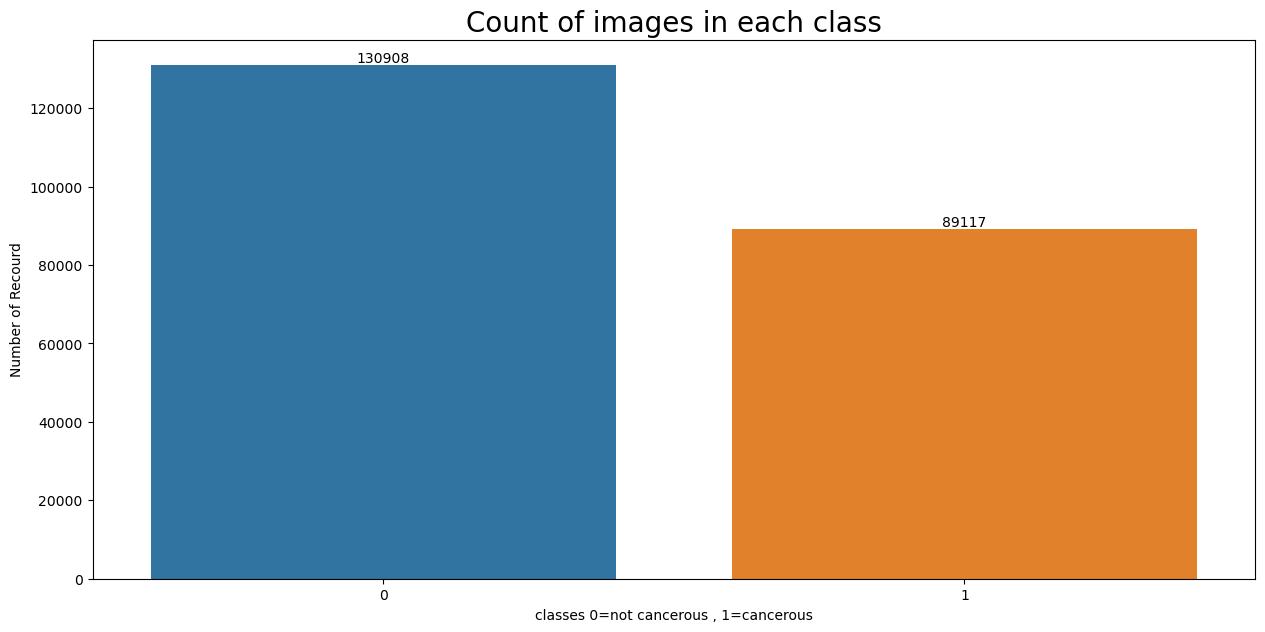

In [9]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_labels_df , x=train_labels_df['label'])

plt.xlabel('classes 0=not cancerous , 1=cancerous')
plt.ylabel('Number of Recourd')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

We have 220,025 images in the train data set with 2 unique labels. 0 for not cancerous and 1 for cancerous tissues.

## Label 0 = Not-Cancerous
## Label 1 = Cancerous

In [10]:
train_labels_df['label'].value_counts(normalize = True)

0    0.594969
1    0.405031
Name: label, dtype: float64

In [11]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


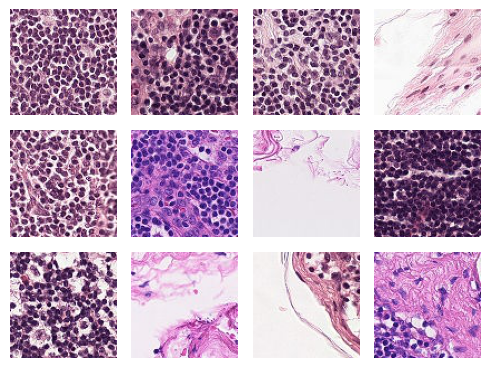

In [12]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


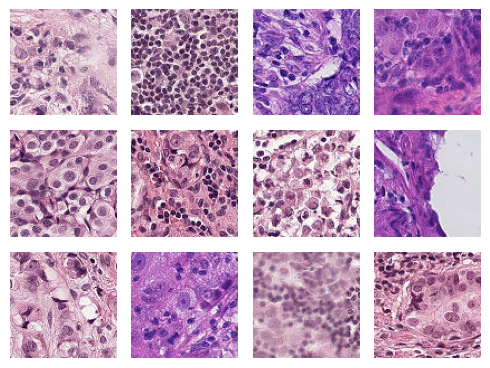

In [13]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

## 3. Model Designing

In this part we will perform various steps required to properly create the Resnet 50 model. We will load the data from the disk, specify train and validation data generators while creating test generator for the final submission.

We will then create a modified Resnet 50 suited for this task.

In [14]:
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

In [15]:
class_0_df = train_labels_df[train_labels_df['label'] == '0']
class_1_df = train_labels_df[train_labels_df['label'] == '1']

# Oversample class 1 to match class 0
class_1_oversampled_df = class_1_df.sample(len(class_0_df), replace=True, random_state=42)

# Combine the oversampled class 1 with class 0
train_labels_df = pd.concat([class_0_df, class_1_oversampled_df])
train_labels_df = train_labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_labels_df.shape

(261816, 3)

In [16]:
train_labels_df.head()

,id,label,filename
0,544266ea6f0f7c98c80e17030cae00458b38acb4,1,/kaggle/input/histopathologic-cancer-detection...
1,691cc7133a8fb4fda2208bcd43797effdeb19bce,0,/kaggle/input/histopathologic-cancer-detection...
2,a4bfe486a2ddcfa3edd0db2089dd59ffe2e7b9ce,0,/kaggle/input/histopathologic-cancer-detection...
3,7a2e2a5afe3adc21d19db61abe22bad9d3790b50,1,/kaggle/input/histopathologic-cancer-detection...
4,f3e857ced80ab4be02fbe3d0bd8da1910f18aad6,0,/kaggle/input/histopathologic-cancer-detection...


# Data After Oversampling

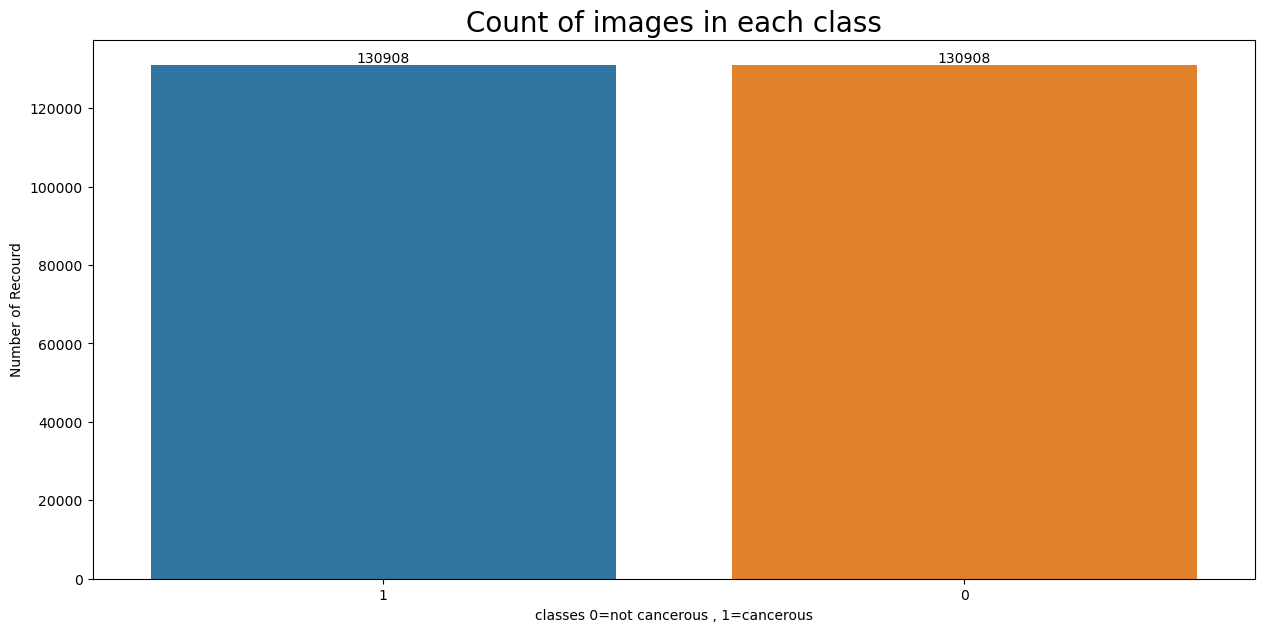

In [17]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_labels_df , x=train_labels_df['label'])

plt.xlabel('classes 0=not cancerous , 1=cancerous')
plt.ylabel('Number of Recourd')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [19]:
train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "training",
    validate_filenames = False,
    seed = 10
)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe=train_labels_df,
    x_col = "filename",
    y_col = "label",
    target_size=(96, 96),
    color_mode = "rgb",
    batch_size = 32,
    class_mode = "binary",
    subset = "validation",
    validate_filenames = False,
    seed = 10
)

Found 209453 non-validated image filenames belonging to 2 classes.
Found 52363 non-validated image filenames belonging to 2 classes.


In [20]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 64,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 10
)

Found 57458 non-validated image filenames.


In [21]:
train_steps = 209453//32  # 8000 images for training
val_steps = 52363//32  

Now we will create Resnet50 model.

It is to be noted that we can actually use transfer learning and import the model and its trained parameters based on imagenet from the tensorflow API. But for this project we will create a modified model.

There will be two types of blocks, identity blocks where input and output dimension remains the same, and convolutional blocks where input and output dimensions are allowed to be changed. In both blocks we will use strong skip connections.

After convolutional we will use fully collected layers with output being a dense Sigmoid unit.

In the end we will have a Resnet model with 50 layers.

In [22]:
def identity_block(X, f, filters, training=True, initializer = random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = tfl.Activation('relu')(X)
    
    ## Set the padding = 'same'
    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = 1, padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training)
    X = tfl.Activation('relu')(X)


    ## Set the padding = 'valid'
    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding = 'valid', kernel_initializer = initializer(seed = 0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)

    return X


In [23]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer = glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    X = tfl.Conv2D(filters = F2, kernel_size = (f,f), strides = 1, padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X) 

    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = 1, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training) 

    X_shortcut = tfl.Conv2D(filters = F3, kernel_size = (1,1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

In [24]:
def ResNet50(input_shape = (96, 96, 3)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = tfl.Input(input_shape)

    
    # Zero-Padding
    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(96, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    # Use the instructions above in order to implement all of the Stages below
    # Make sure you don't miss adding any required parameter
    
    ## Stage 3 (≈4 lines)
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    # the 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    # add `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    # the 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D()(X)"
    X = tfl.AveragePooling2D(pool_size = (2,2))(X)
    

    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(1, kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [25]:
model = ResNet50(input_shape = (96, 96, 3))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 96)   14208       ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                   

Above is the model summary. We have 23,551,681 trainable parameters. If we use more deeper network number of parameters will increase with possible increase in Accuracy or AUC. But for this model we will use resnet 50 only.

## 4. Model Deployment

In [26]:
from IPython.display import Image
Image(url="https://wisdomml.in/wp-content/uploads/2023/03/resnet_bannner.png")

In this part we will use the model created and fit the model with Adam optimizer and loss as binary cross entropy. We have used from logits = True for better accuracy. If reader wants to avoid it they can modify the last output layer in Resnet50 above and make the Activation function as sigmoid instead of linear.

# Create F1 - Score Metric for Classification Evaluation 

In [25]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

In [28]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

In [29]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
6545/6545 [==============================] - 1340s 198ms/step - loss: 0.3632 - accuracy: 0.8379 - auc: 0.8703 - f1_score: 0.8248 - val_loss: 0.3284 - val_accuracy: 0.8520 - val_auc: 0.8807 - val_f1_score: 0.8448
Epoch 2/10
6545/6545 [==============================] - 469s 72ms/step - loss: 0.2577 - accuracy: 0.8908 - auc: 0.9142 - f1_score: 0.8846 - val_loss: 0.2565 - val_accuracy: 0.9013 - val_auc: 0.9232 - val_f1_score: 0.8999
Epoch 3/10
6545/6545 [==============================] - 468s 72ms/step - loss: 0.2008 - accuracy: 0.9179 - auc: 0.9362 - f1_score: 0.9136 - val_loss: 0.1943 - val_accuracy: 0.9225 - val_auc: 0.9396 - val_f1_score: 0.9191
Epoch 4/10
6545/6545 [==============================] - 472s 72ms/step - loss: 0.1678 - accuracy: 0.9330 - auc: 0.9481 - f1_score: 0.9298 - val_loss: 0.1567 - val_accuracy: 0.9403 - val_auc: 0.9543 - val_f1_score: 0.9382
Epoch 5/10
6545/6545 [==============================] - 470s 72ms/step - loss: 0.1449 - accuracy: 0.9435 - auc: 0.

In [30]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

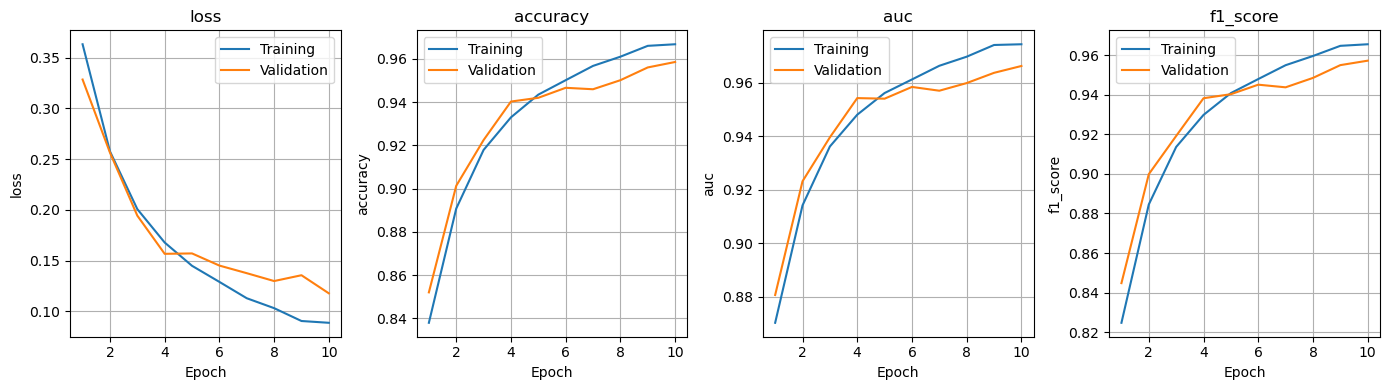

In [31]:
history_modelrestnet = merge_history([history])
vis_training(history_modelrestnet)

It takes around 2 hours to train the model with 10 epochs and Kaggle P100 GPU. We can increase the number of epochs but only Training loss decrease for some time after 10 epochs with little change in validation loss and accuracy. In fact we can see from above that after 6th Epoch Validation Accruacy has not changed much.

So, it will not be efficient to train with more epochs but readers can do it if they have resources and time for this.

## 5. Model Evaluation

Above we have used a threshold of 0.5 which is just assumed and is totally not correct. There was no decision boundary given with the dataset so we cant use above metrics to test the performance of the model.

In order to test the model performance we need to create a submission and get the AUC we will obtain from such submission.

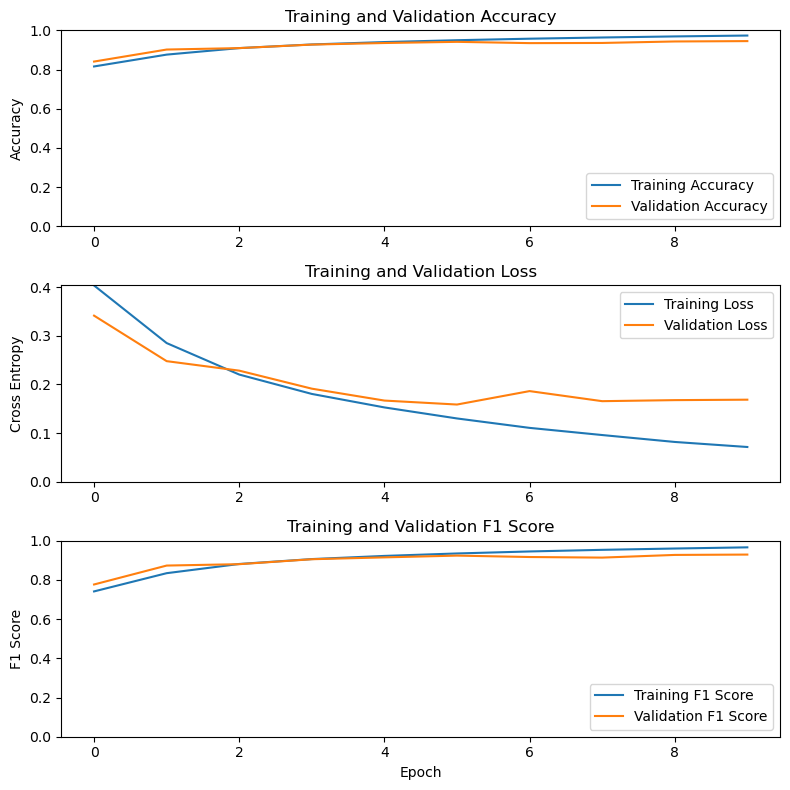

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

F1_score = history.history['f1_score']
F1_score_valid = history.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score, label='Training F1 Score')
plt.plot(F1_score_valid, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 2 --> EfficientNetB0

In [22]:
from IPython.display import Image
Image(url="https://media.licdn.com/dms/image/D4E12AQHL32j_wE3JTw/article-cover_image-shrink_720_1280/0/1669236519664?e=1727308800&v=beta&t=BM4KMl52c-TXWz0C-SCD_MbHo1_rdXaC6UWRhTNqZqo")

In [26]:
base_model_EfficientNetB0 = efn.EfficientNetB0(input_shape=(96,96,3), include_top=False, weights='imagenet')

model_EfficientNetB0 = Sequential([
    base_model_EfficientNetB0,
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_EfficientNetB0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 3, 3, 1280)       4049564   
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               2949376   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

In [27]:
model_EfficientNetB0.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

In [28]:
h1 = model_EfficientNetB0.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-08-04 05:22:17.020521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6545/6545 [==============================] - 2036s 304ms/step - loss: 0.2228 - accuracy: 0.9161 - auc_1: 0.9693 - f1_score: 0.9136 - val_loss: 0.1730 - val_accuracy: 0.9336 - val_auc_1: 0.9892 - val_f1_score: 0.9281
Epoch 2/10
6545/6545 [==============================] - 472s 72ms/step - loss: 0.1475 - accuracy: 0.9489 - auc_1: 0.9856 - f1_score: 0.9470 - val_loss: 0.1191 - val_accuracy: 0.9568 - val_auc_1: 0.9907 - val_f1_score: 0.9558
Epoch 3/10
6545/6545 [==============================] - 478s 73ms/step - loss: 0.1196 - accuracy: 0.9597 - auc_1: 0.9900 - f1_score: 0.9583 - val_loss: 0.1145 - val_accuracy: 0.9588 - val_auc_1: 0.9919 - val_f1_score: 0.9580
Epoch 4/10
6545/6545 [==============================] - 477s 73ms/step - loss: 0.1005 - accuracy: 0.9667 - auc_1: 0.9926 - f1_score: 0.9654 - val_loss: 0.1031 - val_accuracy: 0.9634 - val_auc_1: 0.9927 - val_f1_score: 0.9618
Epoch 5/10
6545/6545 [==============================] - 478s 73ms/step - loss: 0.0865 - accuracy: 0.9714 - au

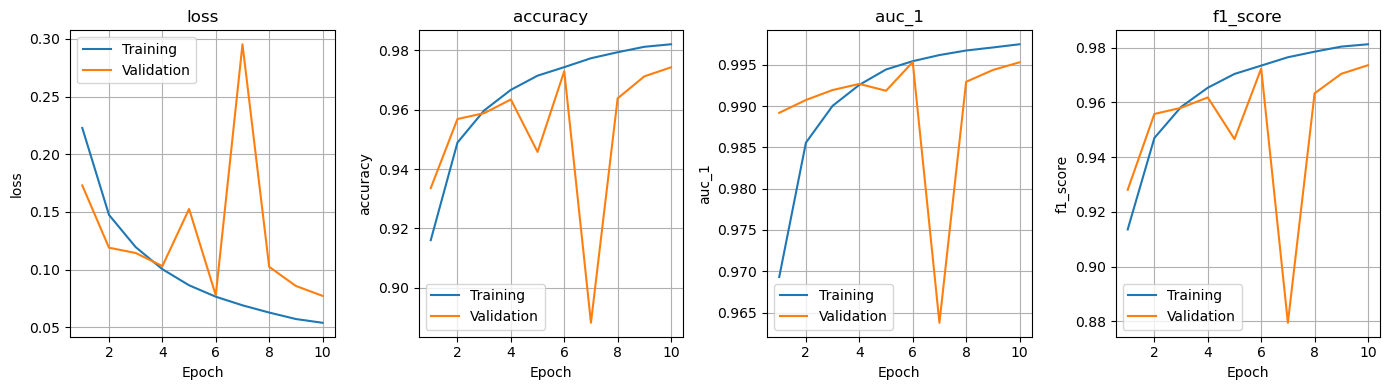

In [31]:
history_model_B0 = merge_history([h1])
vis_training(history_model_B0)

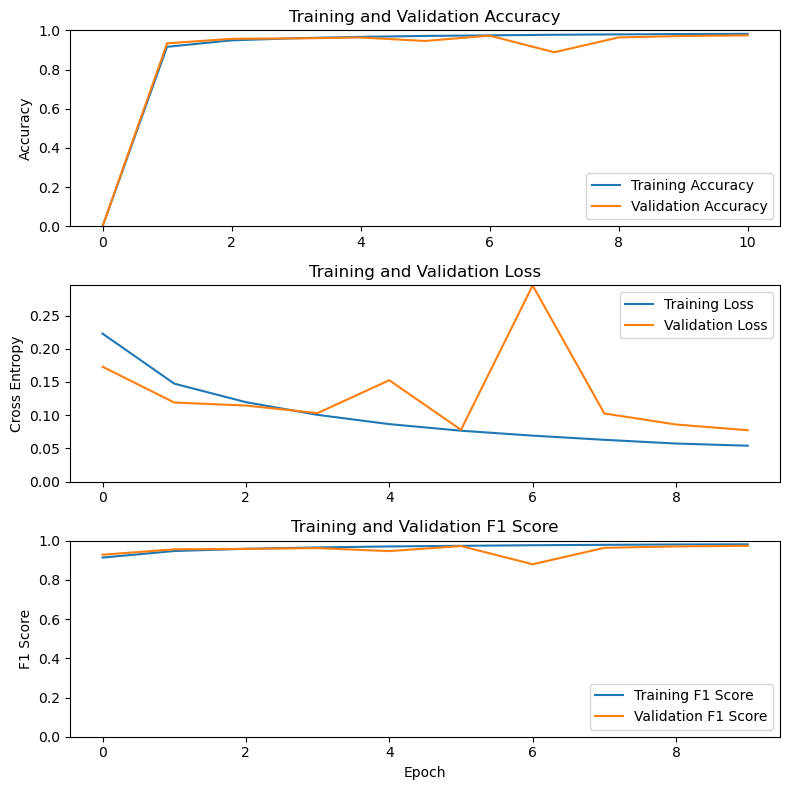

In [32]:
acc_B0 = [0.] + h1.history['accuracy']
val_acc_B0 = [0.] + h1.history['val_accuracy']

loss_B0 = h1.history['loss']
val_loss_B0 = h1.history['val_loss']

F1_score_B0 = h1.history['f1_score']
F1_score_valid_B0 = h1.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc_B0, label='Training Accuracy')
plt.plot(val_acc_B0, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss_B0, label='Training Loss')
plt.plot(val_loss_B0, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss_B0), max(val_loss_B0))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score_B0, label='Training F1 Score')
plt.plot(F1_score_valid_B0, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 3 --> Xception

In [33]:
from IPython.display import Image
Image(url="https://www.ismrm.org/21/program-files/TeaserSlides/abstracts/images/1945/ISMRM2021-001945_Fig6.png")

In [34]:
img_shape=(96, 96,3)
base_model_Xception = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')
    
model_Xception = Sequential([
    base_model_Xception,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(1, activation= 'sigmoid')
])

model_Xception.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

model_Xception.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                       

In [35]:
h2 = model_Xception.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
6545/6545 [==============================] - 557s 81ms/step - loss: 0.2232 - accuracy: 0.9140 - auc_2: 0.9692 - f1_score: 0.9113 - val_loss: 0.1418 - val_accuracy: 0.9483 - val_auc_2: 0.9865 - val_f1_score: 0.9463
Epoch 2/10
6545/6545 [==============================] - 511s 78ms/step - loss: 0.1379 - accuracy: 0.9504 - auc_2: 0.9873 - f1_score: 0.9488 - val_loss: 0.1321 - val_accuracy: 0.9491 - val_auc_2: 0.9908 - val_f1_score: 0.9489
Epoch 3/10
6545/6545 [==============================] - 511s 78ms/step - loss: 0.1028 - accuracy: 0.9639 - auc_2: 0.9926 - f1_score: 0.9626 - val_loss: 0.1730 - val_accuracy: 0.9328 - val_auc_2: 0.9906 - val_f1_score: 0.9343
Epoch 4/10
6545/6545 [==============================] - 510s 78ms/step - loss: 0.0808 - accuracy: 0.9722 - auc_2: 0.9950 - f1_score: 0.9713 - val_loss: 0.1083 - val_accuracy: 0.9620 - val_auc_2: 0.9927 - val_f1_score: 0.9605
Epoch 5/10
6545/6545 [==============================] - 508s 78ms/step - loss: 0.0641 - accuracy: 0.

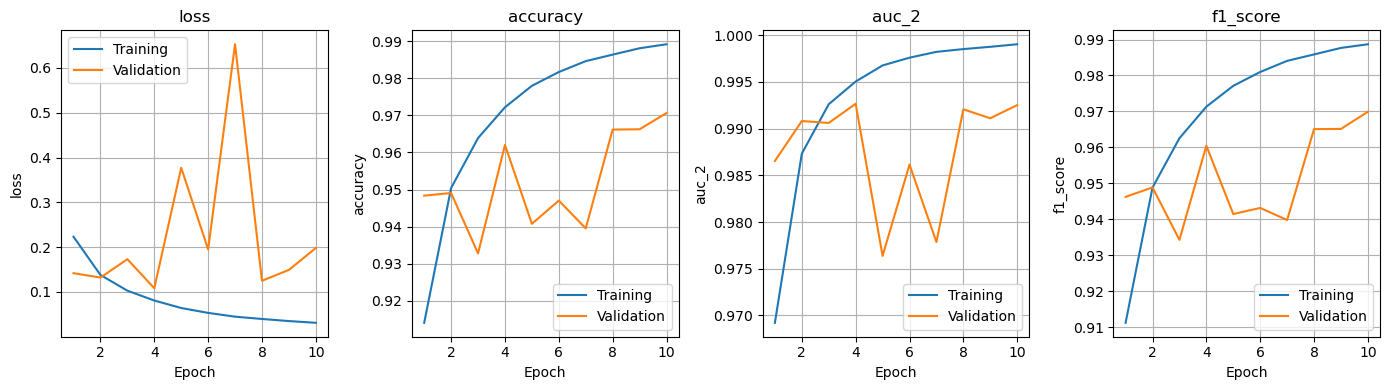

In [36]:
history_model_Xception = merge_history([h2])
vis_training(history_model_Xception)

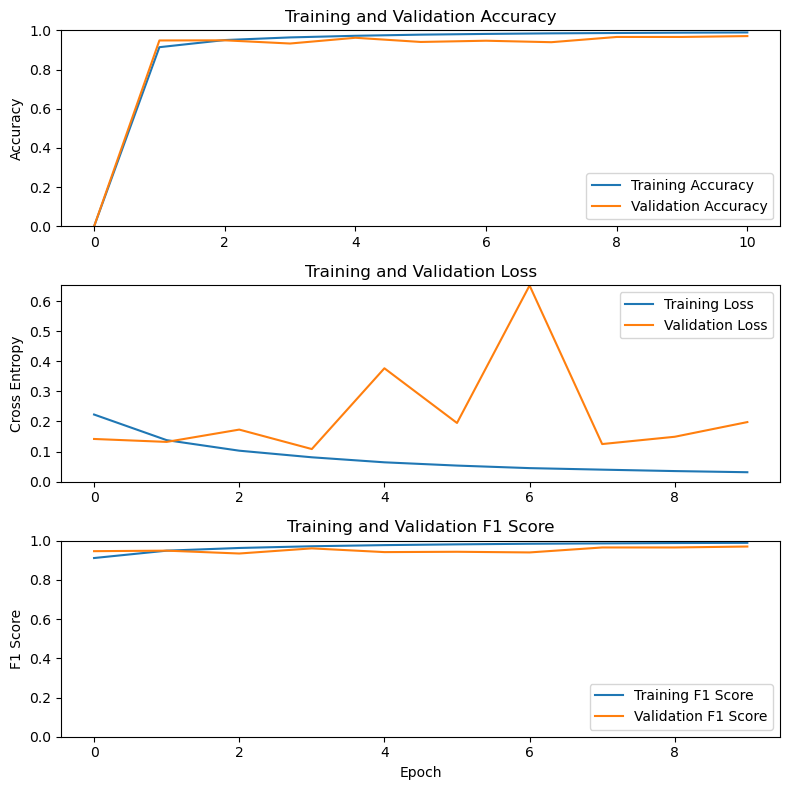

In [37]:
acc_Xception = [0.] + h2.history['accuracy']
val_acc_Xception = [0.] + h2.history['val_accuracy']

loss_Xception = h2.history['loss']
val_loss_Xception = h2.history['val_loss']

F1_score_Xception = h2.history['f1_score']
F1_score_valid_Xception = h2.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc_Xception, label='Training Accuracy')
plt.plot(val_acc_Xception, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss_Xception, label='Training Loss')
plt.plot(val_loss_Xception, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss_Xception), max(val_loss_Xception))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score_Xception, label='Training F1 Score')
plt.plot(F1_score_valid_Xception, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Model 4 --> DenseNet121

In [38]:
from IPython.display import Image
Image(url="https://www.researchgate.net/publication/357102154/figure/fig1/AS:1101806226681856@1639702483586/DenseNet121-architecture-with-three-dense-blocks-Layers-between-two-adjacent-blocks-are_W640.jpg")

In [39]:
from tensorflow.keras.applications import DenseNet121

base_model_DenseNet121 = DenseNet121(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

model_DenseNet121 = Sequential([
    base_model_DenseNet121,
    
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_DenseNet121.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score])

# Print the model summary
model_DenseNet121.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2359552   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 32)                8224      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                       

In [40]:
h3 = model_DenseNet121.fit(
    train_generator,
    steps_per_epoch = train_steps,
    validation_data = validation_generator,
    validation_steps = val_steps,
    epochs = 10
)

Epoch 1/10
6545/6545 [==============================] - 700s 96ms/step - loss: 0.2581 - accuracy: 0.9002 - auc_3: 0.9594 - f1_score: 0.8972 - val_loss: 0.4598 - val_accuracy: 0.8391 - val_auc_3: 0.9565 - val_f1_score: 0.8549
Epoch 2/10
6545/6545 [==============================] - 622s 95ms/step - loss: 0.1806 - accuracy: 0.9346 - auc_3: 0.9793 - f1_score: 0.9324 - val_loss: 0.2105 - val_accuracy: 0.9156 - val_auc_3: 0.9756 - val_f1_score: 0.9094
Epoch 3/10
6545/6545 [==============================] - 619s 95ms/step - loss: 0.1491 - accuracy: 0.9469 - auc_3: 0.9855 - f1_score: 0.9452 - val_loss: 0.2291 - val_accuracy: 0.9097 - val_auc_3: 0.9804 - val_f1_score: 0.9125
Epoch 4/10
6545/6545 [==============================] - 620s 95ms/step - loss: 0.1275 - accuracy: 0.9554 - auc_3: 0.9891 - f1_score: 0.9538 - val_loss: 1.7829 - val_accuracy: 0.7047 - val_auc_3: 0.8141 - val_f1_score: 0.5740
Epoch 5/10
6545/6545 [==============================] - 627s 96ms/step - loss: 0.1118 - accuracy: 0.

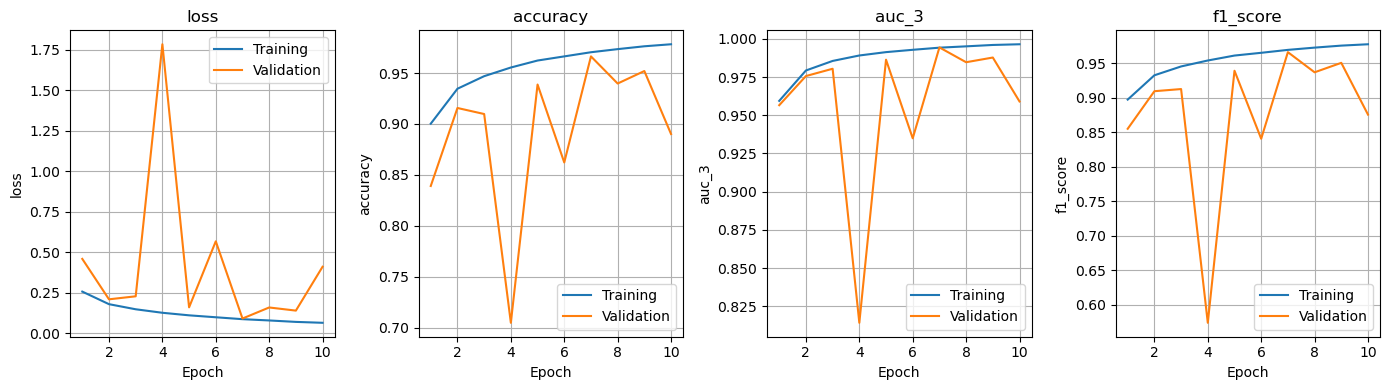

In [41]:
history_model_DenseNet121 = merge_history([h3])
vis_training(history_model_DenseNet121)

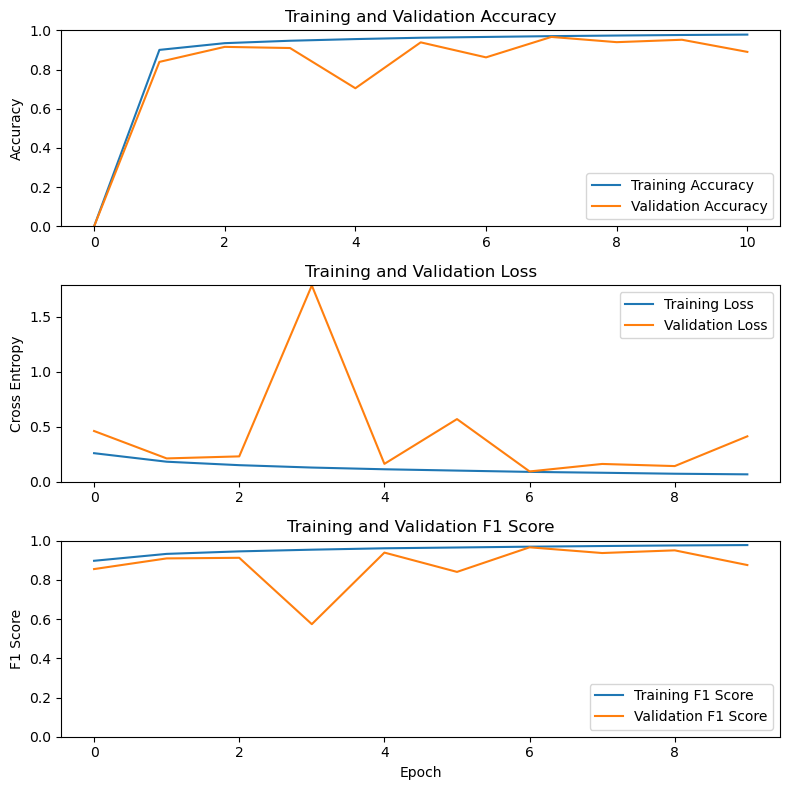

In [42]:
acc_DenseNet121 = [0.] + h3.history['accuracy']
val_acc_DenseNet121 = [0.] + h3.history['val_accuracy']

loss_DenseNet121 = h3.history['loss']
val_loss_DenseNet121 = h3.history['val_loss']

F1_score_DenseNet121 = h3.history['f1_score']
F1_score_valid_DenseNet121 = h3.history['val_f1_score']

plt.figure(figsize=(8, 8))

# Plot Training and Validation Accuracy
plt.subplot(3, 1, 1)
plt.plot(acc_DenseNet121, label='Training Accuracy')
plt.plot(val_acc_DenseNet121, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(3, 1, 2)
plt.plot(loss_DenseNet121, label='Training Loss')
plt.plot(val_loss_DenseNet121, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss_DenseNet121), max(val_loss_DenseNet121))])
plt.title('Training and Validation Loss')

# Plot Training and Validation F1 Score
plt.subplot(3, 1, 3)
plt.plot(F1_score_DenseNet121, label='Training F1 Score')
plt.plot(F1_score_valid_DenseNet121, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.ylim([0, 1])
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()